# 4. Kernel Methods

In contrast to the idea of dimensionality reduction and compression, another popular direction in Machine Learning 
considers the opposite approach of solving problems in a higher-dimensional space. In this notebook we present the 
general idea of **kernel methods** on the example of

* Kernel ridge regression and
* Gaussian Processes

mostly focusing on simulated data to highlight their main benefits.

Keywords: ```feature mapping```, ```RBF kernel```, ```sklearn.kernel_ridge.KernelRidge```, 
 ```sklearn.gaussian_process.GaussianProcessRegressor```, ```sklearn.gaussian_process.kernels.RBF```
 ```sklearn.pipeline.make_pipeline```, ```sklearn.preprocessing.StandardScaler```

***

## Lifting Data into higher Dimensions

All models considered in the previous notebooks can be regarded as essentially linear models. Although linear models have 
their advantages (in particular with respect to mathemical derivations and guarantees), they severly limit the kind of 
functions we can represent. A common approach therefore is to **map** the problem from the input space into a 
**higher-dimensional feature space** as illustrated in the next figure for a classification setting.

<center><img src="images/Lifting.png" alt="Lifting Data into Higher-Dimensions" width="600"/></center>

The feature mapping $\phi$ allows us to map data from a lower-dimensional input space into a higher-dimensional feature 
space. The key idea is that identifying the complicated decision boundary in input space might be challenging, but
**in feature space a linear model suffices** to identify the planar decision boundary. 

More importantly, we can show that we do not need to ever evaluate $\phi(x)$. We can rely on the **kernel trick**!
This implies that we only need to evalute scalar products of feature mappings -- called kernels -- $\kappa(x,x')=\langle \phi(x),\phi(x')\rangle$ for pairs of datapoints $x,x'$ in our dataset $X$.

One such wildly used kernel is the 
**radial basis function (RBF) kernel**

\begin{equation}
    \kappa (x,x') = \exp \Big( - \frac{1}{2\sigma^2} \Vert x - x' \Vert_2^2 \Big)
\end{equation}

which corresponds to an infinite-dimensional feature space. In general, we can design task-dependent kernels which might
extract features we deem relevant to our problem. Furthermore, we can "kernelise" standard linear approaches to 
become more powerful!

***

## Kernel Ridge Regression

We revisit our standard regression techniques and see how the kernelised version extends what we have 
seen before. We formulated the linear regression model before as

\begin{equation}
    Y = Xw + \epsilon.
\end{equation}

Let's simulate a sinusoidal dataset (with noise) of $N=200$ datapoints.

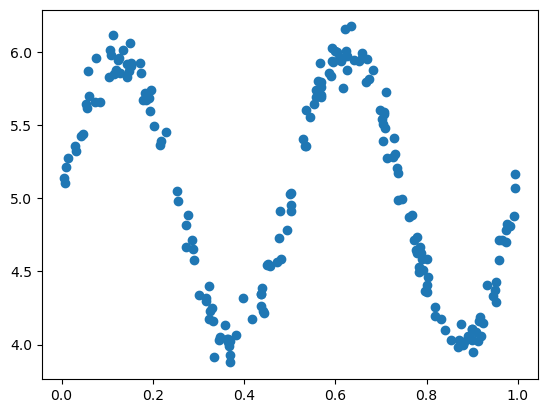

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

num_datapoints = 200
X = np.random.rand(num_datapoints)
X = np.sort(X).reshape(-1,1)

Y = np.sin(4 * np.pi * X) + np.random.randn(num_datapoints, 1) * 0.1 + 5

plt.scatter(X,Y)
plt.show()

As we have seen before, we will try to fit these observations with a
polynomial with linear and ridge regression. 

In the following, we make use of an advanced ```scikit-learn``` tool.
We build a **pipeline** (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline))
which allows data processing steps to be executed with an estimator like  ```LinearRegression``` or ```Ridge```. 
In particular, we use the ```StandardScalar``` method (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) which is a method to 
standardise our dataset, i.e. subtract the sample mean and divide by the sample
standard deviation. With such a pipeline we can do some "data curation" before
training!

Rsquared_lin = 0.89, Rsquared_ridge = 0.55


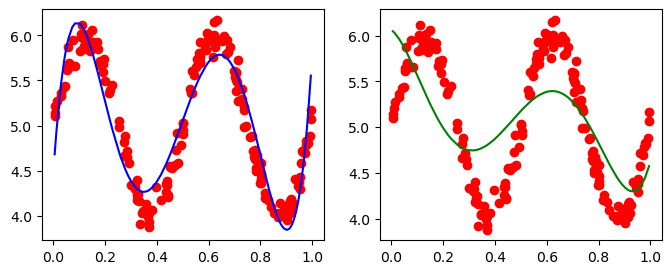

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_poly = np.hstack((X, X ** 2, X ** 3, X ** 4, X ** 5))

linreg = make_pipeline(StandardScaler(), LinearRegression())
linreg.fit(X_poly,Y)
Y_OLS = linreg.predict(X_poly)
Rsquared_lin = linreg.score(X_poly,Y)

ridgereg = make_pipeline(StandardScaler(), Ridge(alpha=0.001))
ridgereg.fit(X_poly,Y)
Y_ridge = ridgereg.predict(X_poly)
Rsquared_ridge = ridgereg.score(X_poly,Y)

print(f"Rsquared_lin = {Rsquared_lin:.2f}, Rsquared_ridge = {Rsquared_ridge:.2f}")

fig, axs = plt.subplots(1,2, figsize=(8,3))

axs[0].scatter(X[:, 0], Y, color='red')
axs[0].plot(X[:, 0], Y_OLS, color='blue')

axs[1].scatter(X[:, 0], Y, color='red')
axs[1].plot(X[:, 0], Y_ridge, color='green')

plt.show()

### **Kernel Ridge Regression (KRR)** 
incorporates the idea of employing a feature 
mapping $\phi$ and we rewrite the linear regression model as

\begin{equation}
    Y = \phi(X)w + \epsilon = f(x) + \epsilon.
\end{equation}

Similar to the ridge regression result, the solution can be shown to be 

\begin{equation}
    w_\text{KRR} = \phi(X)^\top \left( \phi(X)^\top \phi(X) + \lambda \mathbb{1}_{N} \right)^{-1} Y.
\end{equation}

and the learned function (without going into the mathematical details) is then given by 

\begin{equation}
    f(x) = K(x,X) \left( K(X,X) + \lambda \mathbb{1}_{d_N} \right)^{-1} Y
\end{equation}

with $K$ being the kernel matrix $K_{nm} = \kappa(x_n, x_m) = \langle \phi(x_n),\phi(x_m)\rangle$. 

Let's see how we can make use of for the above dataset and define the RBF kernel.

In [3]:
def rbf_kernel(x1, x2, sigma=1.0):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

As usually, we use a ```scikit-learn``` estimator: [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html).

Rsquared_lin = 0.89, Rsquared_ridge = 0.55, Rsquared_KRR = 0.98


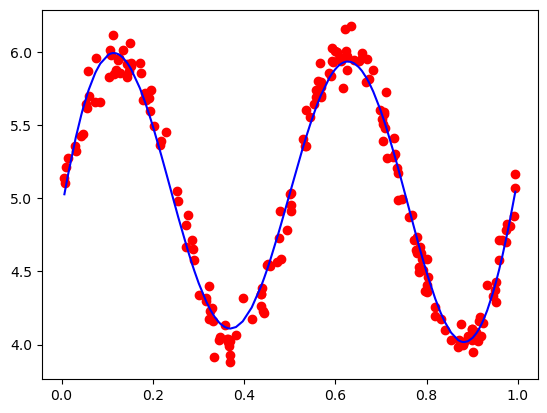

In [4]:
from sklearn.kernel_ridge import KernelRidge

KRR = make_pipeline(StandardScaler(), KernelRidge(kernel=rbf_kernel, alpha=0.01, gamma=0.1))
KRR.fit(X, Y)
Y_KRR = KRR.predict(X)

Rsquared_KRR = KRR.score(X,Y)

print(f"Rsquared_lin = {Rsquared_lin:.2f}, Rsquared_ridge = {Rsquared_ridge:.2f}, Rsquared_KRR = {Rsquared_KRR:.2f}")

plt.scatter(X[:, 0], Y, color='red')
plt.plot(X[:, 0], Y_KRR, color='blue')
plt.show()

***

## Gaussian Processes

Kernel Ridge Regression has a close connection to **Gaussian Processes (GPs)** 
([Wikipedia](https://en.wikipedia.org/wiki/Gaussian_process) or [scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)). Informally, a GP 
extends the notion of random variables to random functions. In a regression setting with input 
matrix $X$, the GP prior distribution $p(f \mid X) = \mathcal{N} (0, K)$ allows us to model the 
regression function $f(X)= [f(x_1), ..., f(x_N)]^\top$ as 

\begin{equation}
    \big( f(x_1), ..., f(x_N)\big) \sim \mathcal{N} \left( 0, K \right)
\end{equation}

with sample covariance matrix $K=\text{cov}(X,X)$. Let us consider a GP regression model with noisy 
responses $Y$ as before, i.e.

\begin{equation}
    Y = f(x) + \epsilon.
\end{equation}

Leaving the mathematical derivation aside, in order to make a prediction for function $f(x)$ 
with new (test) data $x$, we can show that the posterior predictive distribution 
([Wikipedia](https://en.wikipedia.org/wiki/Posterior_predictive_distribution)) has the form

\begin{align}
    p(f \mid x, X, Y) &= \mathcal{N} ( \mu(x), \Sigma(x,X) )  \\
    \mu(x) &= K(x,X) \big( K(X,X) + \lambda\mathbb{1}_N \big)^{-1}  Y \\
    \Sigma(x,X) &= K(x,x) - K(x,X)^\top  \left( K(X,X) + \lambda \mathbb{1}_N \right)^{-1} K(x,X)
\end{align}

Note that what we have written earlier for $f(x)$ in KRR **corresponds exactly** to $\mu(x)$ in
GP regression, i.e. there is a close connection between KRR and GP regression (see e.g. [this comparison](https://scikit-learn.org/0.24/auto_examples/gaussian_process/plot_compare_gpr_krr.html)). This motivates that
the **covariance matrix $K$ is a kernel**, too! Compared to KRR, GPs can be more flexible (as we can sample
functions from the posterior) and we can make use of the GP formalism for training. Also, GPs enable us to quantify the uncertainty 
of a prediction due to $\Sigma(x,X)$. 

Let's study this in a simplified example with $N=4$ datapoints. As always, we can use
```scikit-learn``` methods for the [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) and different kernels.
We employ the [RBF](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) kernel as well as a 
[ConstantKernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html), i.e.
$\kappa (x,x') = \text{const}$.

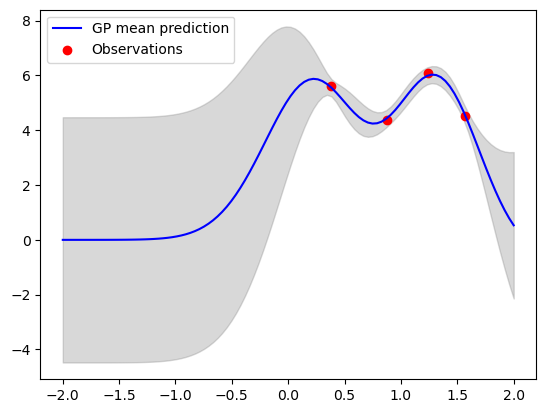

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

np.random.seed(1234)

num_datapoints = 4

X = np.random.rand(num_datapoints, 1)*2
Y = np.sin(2 * np.pi * X) + np.random.randn(num_datapoints, 1) * 0.1 + 5

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.001, 1000)) 
kernel = kernel * RBF(length_scale=0.5, length_scale_bounds=(0.01, 100))

GPreg = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)
GPreg.fit(X, Y)

X_pred = np.linspace(-2.0, 2.0, 100).reshape(-1, 1)
Y_GPreg, stddev_GPreg = GPreg.predict(X_pred, return_std=True)

X_pred = X_pred.reshape(-1)
Y_GPreg = Y_GPreg.reshape(-1)

plt.fill_between(X_pred, Y_GPreg - stddev_GPreg,  Y_GPreg + stddev_GPreg, alpha=0.3, color='grey')
plt.plot(X_pred, Y_GPreg, color='blue', label='GP mean prediction')
plt.scatter(X, Y, color='red', label='Observations')

plt.legend(loc='upper left')
plt.show()

***

## Exercise Section

For the exercises, we consider again the red wine dataset but this time train a 
(1.) kernel ridge regressor and (2.) Gaussian Process regressor. As in notebook 2, 
we want to predict the ```quality``` values on the test set ```feat_test``` and 
compare the mean squared errors (MSEs) of KRR and GP regression to the previous 
results for ridge regression (0.42) and Random Forest regression (0.34).

In order, to prepare the data and kernel, load the following cell:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

np.random.seed(1234)

ex_kernel = RBF(length_scale=5, length_scale_bounds=(0.01, 100))

wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

ex_target = wine_data['quality']
ex_features = wine_data.drop(['quality'], axis=1)

feat_train, feat_test, target_train, target_test = train_test_split(
    ex_features, ex_target, test_size = 0.3, random_state=123)

target_test = target_test.to_frame()

In [13]:
feat_train.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
374,14.0,0.410,0.63,3.8,0.089,6.0,47.0,1.00140,3.01,0.81,10.800000
800,7.2,0.610,0.08,4.0,0.082,26.0,108.0,0.99641,3.25,0.51,9.400000
1441,7.4,0.785,0.19,5.2,0.094,19.0,98.0,0.99713,3.16,0.52,9.566667
1269,5.5,0.490,0.03,1.8,0.044,28.0,87.0,0.99080,3.50,0.82,14.000000
691,9.2,0.920,0.24,2.6,0.087,12.0,93.0,0.99980,3.48,0.54,9.800000


In [14]:
target_train.head(5)

374     6
800     5
1441    6
1269    8
691     5
Name: quality, dtype: int64

(1.) Implement kernel ridge regression as we have seen it in this notebook. 
Please provide the predictions for the test set ```feat_test``` in ```ex_pred_KRR```.

In [ ]:
# Fill in

We use ```ex_pred_KRR``` in the following cell to provide the results. 
You can just execute the next cell.

In [ ]:
target_test['KRR_predicted_quality'] = np.around(ex_pred_KRR, decimals=2)
target_test['KRR_absolut_deviation'] = abs(target_test['quality'] - target_test['KRR_predicted_quality'])
print(target_test)

KRR_pred_MSE = (target_test['KRR_absolut_deviation']**2).mean()
print(f"\nMean squared error of KernelRidge: {KRR_pred_MSE:.2f}")

(2.) Implement GP regression as we have seen it in this notebook. 
Please provide the predictions for the test set ```feat_test``` in ```ex_pred_GPreg```.

**For Noto users**: You might want to set ```n_restarts_optimizer=1```(i.e. only one), as otherwise 
the computation might take too long.

In [ ]:
# Fill in

We use ```ex_pred_GPreg``` in the following cell to provide the results. 
You can just execute the next cell.

In [ ]:
target_test['GPreg_predicted_quality'] = np.around(ex_pred_GPreg, decimals=2)
target_test['GPreg_absolut_deviation'] = abs(target_test['quality'] - target_test['GPreg_predicted_quality'])
print(target_test)

GPreg_pred_MSE = (target_test['GPreg_absolut_deviation']**2).mean()

print(f"\nMean squared error of GaussianProcessRegressor: {GPreg_pred_MSE:.2f}")
print(f"Mean squared error of KernelRidge: {KRR_pred_MSE:.2f}")

***

## Proposed Solutions

For the exercises, we consider again the red wine dataset but this time train a 
(1.) kernel ridge regressor and (2.) Gaussian Process regressor. As in notebook 2, 
we want to predict the ```quality``` values on the test set ```feat_test``` and 
compare the mean squared errors (MSEs) of KRR and GP regression to the previous 
results for ridge regression (0.42) and Random Forest regression (0.34).

In order, to prepare the data and kernel, load the following cell:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

np.random.seed(1234)

ex_kernel = RBF(length_scale=5, length_scale_bounds=(0.01, 100))

wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

ex_target = wine_data['quality']
ex_features = wine_data.drop(['quality'], axis=1)

feat_train, feat_test, target_train, target_test = train_test_split(
    ex_features, ex_target, test_size = 0.3, random_state=123)

target_test = target_test.to_frame()

(1.) Implement kernel ridge regression as we have seen it in this notebook. 
Please provide the predictions for the test set ```feat_test``` in ```ex_pred_KRR```.

In [7]:
from sklearn.kernel_ridge import KernelRidge

KRR_ex = make_pipeline(StandardScaler(), KernelRidge(kernel=ex_kernel, alpha=0.1))
KRR_ex.fit(feat_train, target_train)
ex_pred_KRR = KRR_ex.predict(feat_test)

Rsquared_KRR_ex = KRR_ex.score(feat_train, target_train)

We use ```ex_pred_KRR``` in the following cell to provide the results. 
You can just execute the next cell.

In [8]:
target_test['KRR_predicted_quality'] = np.around(ex_pred_KRR, decimals=2)
target_test['KRR_absolut_deviation'] = abs(target_test['quality'] - target_test['KRR_predicted_quality'])
print(target_test)

KRR_pred_MSE = (target_test['KRR_absolut_deviation']**2).mean()
print(f"\nMean squared error of KernelRidge: {KRR_pred_MSE:.2f}")

      quality  KRR_predicted_quality  KRR_absolut_deviation
912         6                   6.32                   0.32
772         5                   4.87                   0.13
1037        5                   5.04                   0.04
1106        6                   6.45                   0.45
263         5                   5.58                   0.58
...       ...                    ...                    ...
1466        7                   5.60                   1.40
580         5                   4.71                   0.29
1082        6                   5.37                   0.63
1279        7                   6.25                   0.75
1155        5                   5.37                   0.37

[480 rows x 3 columns]

Mean squared error of KernelRidge: 0.38


(2.) Implement GP regression as we have seen it in this notebook. 
Please provide the predictions for the test set ```feat_test``` in ```ex_pred_GPreg```.

**For Noto users**: You might want to set ```n_restarts_optimizer=1```(i.e. only one), as otherwise 
the computation might take too long.

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor

GPreg_ex = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=ex_kernel, alpha=0.15, n_restarts_optimizer=5))
GPreg_ex.fit(feat_train, target_train)
ex_pred_GPreg = GPreg_ex.predict(feat_test)

Rsquared_GPreg_ex = GPreg_ex.score(feat_train, target_train)

We use ```ex_pred_GPreg``` in the following cell to provide the results. 
You can just execute the next cell.

In [11]:
target_test['GPreg_predicted_quality'] = np.around(ex_pred_GPreg, decimals=2)
target_test['GPreg_absolut_deviation'] = abs(target_test['quality'] - target_test['GPreg_predicted_quality'])
print(target_test)

GPreg_pred_MSE = (target_test['GPreg_absolut_deviation']**2).mean()

print(f"\nMean squared error of GaussianProcessRegressor: {GPreg_pred_MSE:.2f}")
print(f"Mean squared error of KernelRidge: {KRR_pred_MSE:.2f}")

      quality  KRR_predicted_quality  KRR_absolut_deviation  \
912         6                   6.32                   0.32   
772         5                   4.87                   0.13   
1037        5                   5.04                   0.04   
1106        6                   6.45                   0.45   
263         5                   5.58                   0.58   
...       ...                    ...                    ...   
1466        7                   5.60                   1.40   
580         5                   4.71                   0.29   
1082        6                   5.37                   0.63   
1279        7                   6.25                   0.75   
1155        5                   5.37                   0.37   

      GPreg_predicted_quality  GPreg_absolut_deviation  
912                      6.31                     0.31  
772                      4.86                     0.14  
1037                     5.04                     0.04  
1106           